# 2. Apprentissage et déploiement Azure Container Instance (ACI) avec Azure ML services

* Load workspace
* Train a simple regression model directly in the Notebook python kernel
* Record run history
* Find the best model in run history and download it.
* Deploy the model as an Azure Container Instance (ACI)

## Prerequisites
1. Make sure you go through the [00. Installation and Configuration](../../00.configuration.ipynb) Notebook first if you haven't. 

2. Install following pre-requisite libraries to your conda environment and restart notebook.
```shell
(myenv) $ conda install -y matplotlib tqdm scikit-learn
```

3. Check that ACI (Azure Container Instance) is registered for your Azure Subscription.  

In [1]:
!az provider show -n Microsoft.ContainerInstance -o table

Namespace                    RegistrationState
---------------------------  -------------------
Microsoft.ContainerInstance  Registered


If ACI is not registered, run following command to register it. Note that you have to be a subscription owner, or this command will fail.

In [2]:
#!az provider register -n Microsoft.ContainerInstance

## 1 Informations

In [2]:
import sys
print("Version Python : ", sys.version)

Version Python :  3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]


In [3]:
#!pip install azureml-sdk

In [4]:
from azureml.core import Experiment, Run, Workspace
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.74


## 1.1 Workspace

Initialize a workspace object from persisted configuration.

In [5]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Found the config file in: /home/nbuser/library/aml_config/config.json
Workspace name: MLServiceWorkspace
Azure region: westeurope
Subscription id: 70b8f39e-8863-49f7-b6ba-34a80799550c
Resource group: mlserviceresourcegroup


## 1.2 Création expérimentation
Choisir un nom pour l'expérimentation.
Nom entre 3 et 33 caractères !

In [7]:
experiment_name = 'Diabetes'

## 2 Apprentissage local Notebook Sci-kit learn

In [8]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

### 2.1 Simple Ridge model
Train a very simple Ridge regression model in scikit-learn, and save it as a pickle file.

In [9]:
reg = Ridge(alpha = 0.03)
reg.fit(X=data['train']['X'], y=data['train']['y'])
preds = reg.predict(data['test']['X'])
print('MSE = ', mean_squared_error(data['test']['y'], preds))
joblib.dump(value=reg, filename='modele.pkl');

MSE =  3424.900315896017


### 2.2 Ajout tracking expérimentation
Now, let's add Azure ML experiment logging, and upload persisted model into run record as well.

In [10]:
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging()

run.tag("Description","My first run!")
run.log('alpha', 0.03)
reg = Ridge(alpha=0.03)
reg.fit(data['train']['X'], data['train']['y'])
preds = reg.predict(data['test']['X'])
run.log('mse', mean_squared_error(data['test']['y'], preds))
joblib.dump(value=reg, filename='modele.pkl')
run.upload_file(name='outputs/modele.pkl', path_or_stream='./modele.pkl')

run.complete()

We can browse to the recorded run. Please make sure you use Chrome to navigate the run history page.

In [11]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Diabetes,d5e52746-a371-4220-8e47-156125bafa54,,Completed,Link to Azure Portal,Link to Documentation


## 3 Simple parameter sweep
Sweep over alpha values of a sklearn ridge model, and capture metrics and trained model in the Azure ML experiment.

In [12]:
import numpy as np
import os
from tqdm import tqdm

model_name = "modele.pkl"

# list of numbers from 0 to 1.0 with a 0.1 interval
alphas = np.arange(0.0, 1.0, 0.1)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of runs, each train a model with a different alpha value
    with experiment.start_logging() as run:
        # Use Ridge algorithm to build a regression model
        reg = Ridge(alpha=alpha)
        reg.fit(X=data["train"]["X"], y=data["train"]["y"])
        preds = reg.predict(X=data["test"]["X"])
        mse = mean_squared_error(y_true=data["test"]["y"], y_pred=preds)

        # log alpha, mean_squared_error and feature names in run history
        run.log(name="alpha", value=alpha)
        run.log(name="mse", value=mse)
        run.log_list(name="columns", value=columns)

        with open(model_name, "wb") as file:
            joblib.dump(value=reg, filename=file)
        
        # upload the serialized model into run history record
        run.upload_file(name="outputs/" + model_name, path_or_stream=model_name)

        # now delete the serialized model from local folder since it is already uploaded to run history 
        os.remove(path=model_name)

100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


In [13]:
experiment

Name,Workspace,Report Page,Docs Page
Diabetes,MLServiceWorkspace,Link to Azure Portal,Link to Documentation


## 3.3 Choix du meilleur modèle
Load all experiment run metrics recursively from the experiment into a dictionary object.

In [14]:
runs = {}
run_metrics = {}

for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'mse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

22it [00:14,  1.64it/s]


> Now find the run with the **lowest Mean Squared Error** value

In [15]:
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['mse'])
best_run = runs[best_run_id]
print('Meilleur run :', best_run_id)
print('Métriques :', run_metrics[best_run_id])

Meilleur run : 8afab3dc-922a-445c-856c-3028dbe086f1
Métriques : {'alpha': 0.4, 'columns': ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], 'mse': 3295.741064355809}


You can add tags to your runs to make them easier to catalog

In [16]:
best_run.tag(key="Description", value="The best one")
best_run.get_tags()

{'Description': 'The best one'}

### 3.4 MSE x alpha

Let's observe the best model visually by plotting the MSE values over alpha values:

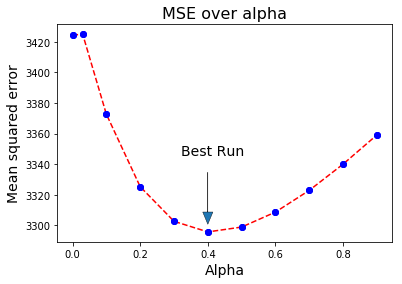

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

best_alpha = run_metrics[best_run_id]['alpha']
min_mse = run_metrics[best_run_id]['mse']

alpha_mse = np.array([(run_metrics[k]['alpha'], run_metrics[k]['mse']) for k in run_metrics.keys()])
sorted_alpha_mse = alpha_mse[alpha_mse[:,0].argsort()]

plt.plot(sorted_alpha_mse[:,0], sorted_alpha_mse[:,1], 'r--')
plt.plot(sorted_alpha_mse[:,0], sorted_alpha_mse[:,1], 'bo')

plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Mean squared error', fontsize = 14)
plt.title('MSE over alpha', fontsize = 16)

# plot arrow
plt.arrow(x = best_alpha, y = min_mse + 39, dx = 0, dy = -26, ls = '-', lw = 0.4,
          width = 0, head_width = .03, head_length = 8)

# plot "best run" text
plt.text(x = best_alpha - 0.08, y = min_mse + 50, s = 'Best Run', fontsize = 14)
plt.show()

## 4 Enregistrement du modèle

Find the model file saved in the run record of best run.

In [18]:
for f in best_run.get_file_names():
    print(f)

outputs/modele.pkl


Now we can register this model in the model registry of the workspace

In [19]:
model = best_run.register_model(model_name='best_model', model_path='outputs/modele.pkl')

Verify that the model has been registered properly. If you have done this several times you'd see the version number auto-increases each time.

In [20]:
from azureml.core.model import Model
models = Model.list(workspace=ws, name='best_model')
for m in models:
    print(m.name, m.version)

best_model 16
best_model 15
best_model 14
best_model 13
best_model 12
best_model 11
best_model 10
best_model 9
best_model 8
best_model 7
best_model 6
best_model 5
best_model 4
best_model 3
best_model 2
best_model 1


You can also download the registered model. Afterwards, you should see a `model.pkl` file in the current directory. You can then use it for local testing if you'd like.

In [21]:
# remove the model file if it is already on disk
if os.path.isfile('modele.pkl'): 
    os.remove('modele.pkl')
# download the model
model.download(target_dir="./")

'./modele.pkl'

## Scoring script

Now we are ready to build a Docker image and deploy the model in it as a web service. The first step is creating the scoring script. For convenience, we have created the scoring script for you. It is printed below as text, but you can also run `%pfile ./score.py` in a cell to show the file.

Tbe scoring script consists of two functions: `init` that is used to load the model to memory when starting the container, and `run` that makes the prediction when web service is called. Please pay special attention to how the model is loaded in the `init()` function. When Docker image is built for this model, the actual model file is downloaded and placed on disk, and `get_model_path` function returns the local path where the model is placed.

In [23]:
%pfile ./score.py

Object `./score.py` not found.


In [24]:
with open('./score.py', 'r') as scoring_script:
    print(scoring_script.read())

import pickle
import json
import numpy as np
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model


def init():
    global model
    # note here "best_model" is the name of the model registered under the workspace
    # this call should return the path to the model.pkl file on the local disk.
    model_path = Model.get_model_path(model_name='best_model')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)


# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)

        # you can return any data type as long as it is JSON-serializable
        return result.tolist()
    except Exception as e:
        result = str(e)
        return result



## Create environment dependency file

We need a environment dependency file `myenv.yml` to specify which libraries are needed by the scoring script when building the Docker image for web service deployment. We can manually create this file, or we can use the `CondaDependencies` API to automatically create this file.

In [25]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=["scikit-learn"])
print(myenv.serialize_to_string())

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==0.1.74
- scikit-learn



## 5 Déploiement web service dans Azure Container Instance (ACI)

The deployment process takes the registered model and your scoring scrip, and builds a Docker image. It then deploys the Docker image into Azure Container Instance as a running container with an HTTP endpoint readying for scoring calls. Read more about [Azure Container Instance](https://azure.microsoft.com/en-us/services/container-instances/).

Note ACI is great for quick and cost-effective dev/test deployment scenarios. For production workloads, please use [Azure Kubernentes Service (AKS)](https://azure.microsoft.com/en-us/services/kubernetes-service/) instead. Please follow in struction in [this notebook](11.production-deploy-to-aks.ipynb) to see how that can be done from Azure ML.
 
> **Note:The web service creation can take 6-7 minutes**.

In [26]:
from azureml.core.webservice import AciWebservice, Webservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'sample name': 'config'}, 
                                               description='deploiement.')

Note the below `WebService.deploy_from_model()` function takes a model object registered under the workspace. It then bakes the model file in the Docker image so it can be looked-up using the `Model.get_model_path()` function in `score.py`. 

If you have a local model file instead of a registered model object, you can also use the `WebService.deploy()` function which would register the model and then deploy.

In [27]:
from azureml.core.image import ContainerImage
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                    runtime="python", 
                                    conda_file="myenv.yml")

In [29]:
%%time
# this will take 5-6 minutes to finish
# you can also use "az container list" command to find the ACI being deployed
#
# Check nom du service avant exécution
service = Webservice.deploy_from_model(name='deployacidiabetes2',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config,
                                       workspace=ws)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image deployacidiabetes2:1, operation "Succeeded"
Creating service
Running.......................................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 2.54 s, sys: 141 ms, total: 2.68 s
Wall time: 6min 56s



## 6 Test du Web Service ACI

In [30]:
print('Web Service dans Azure Container Instance :', service.scoring_uri)

Web Service dans Azure Container Instance : http://13.94.225.211:80/score


Use the `run` API to call the web service with one row of data to get a prediction.

In [31]:
import json
# score the first row from the test set.
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})
service.run(input_data = test_samples)

[217.67978776218712]

Feed the entire test set and calculate the errors (residual values).

In [32]:
# score the entire test set.
test_samples = json.dumps({'data': X_test.tolist()})

result = service.run(input_data = test_samples)
residual = result - y_test

You can also send raw HTTP request to test the web service.

In [33]:
import requests
import json

# 2 rows of input data, each with 10 made-up numerical features
input_data = "{\"data\": [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers = headers)
print(resp.text)

[5215.19813157987, 3726.9954859385766]


## Residual graph
Plot a residual value graph to chart the errors on the entire test set. Observe the nice bell curve.

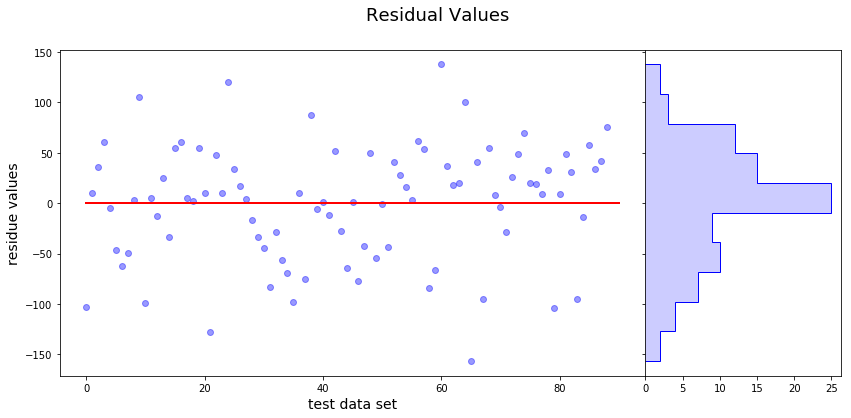

In [34]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Residual Values', fontsize = 18)

f.set_figheight(6)
f.set_figwidth(14)

a0.plot(residual, 'bo', alpha=0.4);
a0.plot([0,90], [0,0], 'r', lw=2)
a0.set_ylabel('residue values', fontsize=14)
a0.set_xlabel('test data set', fontsize=14)

a1.hist(residual, orientation='horizontal', color='blue', bins=10, histtype='step');
a1.hist(residual, orientation='horizontal', color='blue', alpha=0.2, bins=10);
a1.set_yticklabels([])

plt.show()

## 7 Suppression ACI

Nettoyage : supression ACI

In [35]:
%%time
service.delete()

CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 1.69 s


> Fin